In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
import math
from sklearn.metrics import mean_squared_error, roc_auc_score
from KNN.nearest_neighbors import KNNClassifier
from kNN_mmro_packet import distances
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from nltk.corpus import stopwords
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('AB_NYC_2019.csv')
data.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [3]:
data.shape

(48895, 16)

In [4]:
# число значений у признаков
for col_name in data.columns:
    print(col_name, data[col_name].nunique())

id 48895
name 47905
host_id 37457
host_name 11452
neighbourhood_group 5
neighbourhood 221
latitude 19048
longitude 14718
room_type 3
price 674
minimum_nights 109
number_of_reviews 394
last_review 1764
reviews_per_month 937
calculated_host_listings_count 47
availability_365 366


In [3]:
data.isna().sum()

id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

In [3]:
data.name.fillna(data.name.mode()[0], inplace=True)
data.host_name.fillna(data.host_name.mode()[0], inplace=True)

In [4]:
data.last_review.fillna('never', inplace=True)
data.reviews_per_month.fillna(0.0, inplace=True)

In [5]:
data.isna().sum()

id                                0
name                              0
host_id                           0
host_name                         0
neighbourhood_group               0
neighbourhood                     0
latitude                          0
longitude                         0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
last_review                       0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
dtype: int64

In [9]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(columns=['price']), data[['price']],
                                                    test_size=0.3, random_state=1080)

# Часть 1: Алгоритм kNN в задаче регрессии

## Задание 1.1

In [6]:
class KNNRegressor:

    def __init__(self, k, strategy='my_own', metric='euclidean', mode='uniform'):
        if not isinstance(k, int) or k < 1:
            raise AttributeError('Incorrect "k" parameter')
        if not isinstance(mode, str) or mode != 'uniform' and mode != 'distance':
            raise AttributeError('Mode parameter can be uniform or distance only')

        self.mode = mode
        self.k = k
        self.strategy = strategy
        self.metric = metric
        self.training_labels = None
        if strategy == 'my_own':
            self.training_data = None
        else:
            self.nn = NearestNeighbors(n_neighbors=k, algorithm=strategy, leaf_size=30, metric=metric)

    def fit(self, x, y):
        if x.shape[0] != y.shape[0]:
            raise AttributeError('Mismatch between training set and its labels')

        self.training_labels = y
        if self.strategy == 'my_own':
            self.training_data = x
        else:
            self.nn.fit(x)

    def find_kneighbors(self, x, return_distance=True):
        if not isinstance(return_distance, bool):
            raise AttributeError('Incorrect "return_distance" parameter')

        if self.strategy == 'my_own':
            if self.metric == 'euclidean':
                dist_matrix = distances.euclidean_distance(x, self.training_data)
            elif self.metric == 'cosine':
                dist_matrix = distances.cosine_distance(x, self.training_data)
            else:
                dist_matrix = self.metric(self.training_data, x).astype(np.float64).T
            if not return_distance:
                res_index = np.empty(dist_matrix.shape[0], dtype=np.int64)
                tmp_index = np.empty(dist_matrix.shape[0], dtype=np.int64)
                np.argmin(dist_matrix, axis=1, out=res_index)
                dist_matrix[np.arange(dist_matrix.shape[0]), res_index] = np.inf
                res_index = res_index.reshape((-1, 1))
                for i in range(self.k - 1):
                    np.argmin(dist_matrix, axis=1, out=tmp_index)
                    dist_matrix[np.arange(dist_matrix.shape[0]), tmp_index] = np.inf
                    res_index = np.hstack((res_index, tmp_index[:, np.newaxis]))
                return res_index
            else:
                res_index = np.empty(dist_matrix.shape[0], dtype=np.int64)
                tmp_index = np.empty(dist_matrix.shape[0], dtype=np.int64)
                np.argmin(dist_matrix, axis=1, out=res_index)
                res_dist = dist_matrix[np.arange(dist_matrix.shape[0]), res_index]
                dist_matrix[np.arange(dist_matrix.shape[0]), res_index] = np.inf
                res_index = res_index.reshape((-1, 1))
                res_dist = res_dist.reshape((-1, 1))
                for i in range(self.k - 1):
                    np.argmin(dist_matrix, axis=1, out=tmp_index)
                    res_dist = np.hstack((res_dist,
                                          dist_matrix[np.arange(dist_matrix.shape[0]), tmp_index][:, np.newaxis]))
                    dist_matrix[np.arange(dist_matrix.shape[0]), tmp_index] = np.inf
                    res_index = np.hstack((res_index, tmp_index[:, np.newaxis]))
                return res_dist, res_index
        else:
            return self.nn.kneighbors(x, return_distance=return_distance)

    def predict(self, x, k=None):
        if k is not None:
            if not isinstance(k, int) or k < 1:
                raise AttributeError('Incorrect "k" parameter')
            else:
                if self.strategy == 'my_own':
                    self.k = k
                else:
                    params = self.nn.get_params()
                    params['n_neighbors'] = k
                    self.nn = self.nn.set_params(**params)

        if self.mode == 'uniform':
            nn_index = self.training_labels[self.find_kneighbors(x, return_distance=False)]
            return np.mean(nn_index, axis=1)
        else:
            vec_weight = np.vectorize(lambda z: 1 / (z + 0.00001))
            nn_dist, nn_index = self.find_kneighbors(x)
            nn_index = self.training_labels[nn_index]
            nn_dist = vec_weight(nn_dist)
            return np.sum(nn_index * nn_dist, axis=1) / np.sum(nn_dist, axis=1)

# Часть 2: Категориальные признаки

## Задание 2.1

In [11]:
def overlap(x, z):
    return np.apply_along_axis(lambda y: np.sum(y != z, axis=1), axis=1, arr=x)


def flattened_overlap(x, z):

    def vec_fun(y):
        quantities = np.sum(y == x, axis=0)
        res_quantities = np.array([])
        for num, col in enumerate(x.T):
            counts = np.unique(col, return_counts=True)[1]
            res_quantities = np.append(res_quantities, np.sum((counts[counts <= quantities[num]] * (counts[counts <= quantities[num]] - 1)) / (x.shape[0] * (x.shape[0] - 1))))

        return np.sum((y != z) * 1 + (y == z) * res_quantities, axis=1)

    return np.apply_along_axis(vec_fun, axis=1, arr=x)


def log_overlap(x, z):

    def vec_fun(y):
        log_quantities = np.log(np.sum(x == y, axis=0) + 1)
        return np.sum((y != z) * log_quantities * z_counts, axis=1)

    def vec_fun2(y):
        return np.log(np.sum(x == y, axis=0) + 1)

    z_counts = np.apply_along_axis(vec_fun2, axis=1, arr=z)

    return np.apply_along_axis(vec_fun, axis=1, arr=x)

## Задание 2.2

In [12]:
cat_features = ['host_name', 'neighbourhood_group', 'neighbourhood', 'room_type',
                'last_review', 'calculated_host_listings_count', 'availability_365']
X_train_cat = X_train[cat_features]
X_test_cat = X_test[cat_features]

In [13]:
X_train_cat

,host_name,neighbourhood_group,neighbourhood,room_type,last_review,calculated_host_listings_count,availability_365
16456,Kange,Brooklyn,Fort Greene,Entire home/apt,2019-04-06,1,55
22977,Magd,Manhattan,Harlem,Private room,never,1,365
23730,Amy,Queens,Woodside,Private room,2018-11-04,1,10
44303,Noel,Queens,East Elmhurst,Private room,2019-06-14,4,207
21792,Sharon And Dave,Brooklyn,South Slope,Entire home/apt,2019-07-01,1,89
...,...,...,...,...,...,...,...
19044,Caitlin,Manhattan,East Village,Private room,2019-06-24,3,62
43180,Ellen,Manhattan,Financial District,Entire home/apt,2019-06-23,1,2
30842,Eliana,Queens,Astoria,Private room,2019-04-11,1,156
42922,Jill Lauren,Manhattan,Upper East Side,Entire home/apt,2019-06-25,1,61


In [14]:
knn = KNNRegressor(10, metric=overlap, mode='distance')
knn.fit(X_train_cat.to_numpy(), y_train.to_numpy().flatten())
res = knn.predict(X_test_cat.to_numpy())
print(math.sqrt(mean_squared_error(y_test.to_numpy().flatten(), res)))

191.56231050947426


In [15]:
knn = KNNRegressor(10, metric=flattened_overlap, mode='distance')
knn.fit(X_train_cat.to_numpy(), y_train.to_numpy().flatten())
res = knn.predict(X_test_cat.to_numpy())
print(math.sqrt(mean_squared_error(y_test.to_numpy().flatten(), res)))

187.27576847717913


In [16]:
knn = KNNRegressor(10, metric=log_overlap, mode='distance')
knn.fit(X_train_cat.to_numpy(), y_train.to_numpy().flatten())
res = knn.predict(X_test_cat.to_numpy())
print(math.sqrt(mean_squared_error(y_test.to_numpy().flatten(), res)))

191.67449071045965


Лучшей оказалась функция расстояния flattened_overlap. Мне эта функция расстояния показалась наиболее интерпретируемой с логической точки зрения.

## Задание 2.3

In [17]:
models = [KNNRegressor(i, metric=overlap, mode='distance') for i in range(15, 31)]
rmse_list_overlap = []
rmse_list_flattened_overlap = []
rmse_list_log_overlap = []
for knn in models:
    knn.fit(X_train_cat.to_numpy(), y_train.to_numpy().flatten())
    res = knn.predict(X_test_cat.to_numpy())
    rmse_list_overlap.append(math.sqrt(mean_squared_error(y_test.to_numpy().flatten(), res)))
print(rmse_list_overlap)

[182.67981989446594, 181.41060289449888, 180.4845515160916, 179.48557862088623, 178.46350504996474, 177.63783532603344, 177.06644530356863, 176.64221881861175, 176.16802123214538, 175.85376004731296, 175.47803714806744, 174.89130276638056, 174.700263997051, 174.62145916946523, 174.33583160091334, 174.08511466871178]


In [18]:
models = [KNNRegressor(i, metric=flattened_overlap, mode='distance') for i in range(15, 31)]
for knn in models:
    knn.fit(X_train_cat.to_numpy(), y_train.to_numpy().flatten())
    res = knn.predict(X_test_cat.to_numpy())
    rmse_list_flattened_overlap.append(math.sqrt(mean_squared_error(y_test.to_numpy().flatten(), res)))
print(rmse_list_flattened_overlap)

[184.28220911768742, 183.70290364217428, 183.35660183342588, 182.78145440634523, 182.54512231298048, 181.86847584356616, 181.69540699529534, 181.6022903348392, 181.15534769473058, 180.96501573691546, 180.74641627215536, 180.62193529727128, 180.75734861744255, 180.76682039407206, 180.43236099731507, 180.5298902412474]


In [19]:
models = [KNNRegressor(i, metric=log_overlap, mode='distance') for i in range(15, 31)]
for knn in models:
    knn.fit(X_train_cat.to_numpy(), y_train.to_numpy().flatten())
    res = knn.predict(X_test_cat.to_numpy())
    rmse_list_log_overlap.append(math.sqrt(mean_squared_error(y_test.to_numpy().flatten(), res)))
print(rmse_list_log_overlap)

[184.6174728116833, 183.7240281414831, 183.25760938839443, 182.4775119436195, 181.9058136729872, 181.22920878355433, 180.77896877311832, 180.4647918358316, 179.94249340605364, 179.38171425072056, 179.20383920176414, 178.91286968609344, 178.50665075960617, 178.35388033106696, 178.14413337999537, 177.92156513635484]


Для overlap оптимальное k = 30, rmse = 174.09

Для flattened_overlap оптимальное k = 29, rmse = 180.43

Для log_overlap оптимальное k = 30, rmse = 177.92

## Задание 2.4

In [6]:
data['target'] = (data.price > data.price.mean()).astype(int)

In [7]:
data = data.drop(columns=['price', 'id', 'name', 'host_id'])

In [8]:
data

,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,target
0,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,1,9,2018-10-19,0.21,6,365,0
1,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,1,45,2019-05-21,0.38,2,355,1
2,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,3,0,never,0.00,1,365,0
3,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,1,270,2019-07-05,4.64,1,194,0
4,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,10,9,2018-11-19,0.10,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
48890,Sabrina,Brooklyn,Bedford-Stuyvesant,40.67853,-73.94995,Private room,2,0,never,0.00,2,9,0
48891,Marisol,Brooklyn,Bushwick,40.70184,-73.93317,Private room,4,0,never,0.00,2,36,0
48892,Ilgar & Aysel,Manhattan,Harlem,40.81475,-73.94867,Entire home/apt,10,0,never,0.00,1,27,0
48893,Taz,Manhattan,Hell's Kitchen,40.75751,-73.99112,Shared room,1,0,never,0.00,6,2,0


In [9]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(columns=['target']), data[['target']],
                                                    test_size=0.3, random_state=1080)

In [10]:
X_test.latitude = (X_test.latitude.to_numpy() - X_train.latitude.min()) / (X_train.latitude.max() - X_train.latitude.min())
X_train.latitude = (X_train.latitude.to_numpy() - X_train.latitude.min()) / (X_train.latitude.max() - X_train.latitude.min())

In [11]:
X_test.longitude = (X_test.longitude.to_numpy() - X_train.longitude.min()) / (X_train.longitude.max() - X_train.longitude.min())
X_train.longitude = (X_train.longitude.to_numpy() - X_train.longitude.min()) / (X_train.longitude.max() - X_train.longitude.min())

In [12]:
X_test.minimum_nights = (X_test.minimum_nights.to_numpy() - X_train.minimum_nights.min()) / (X_train.minimum_nights.max() - X_train.minimum_nights.min())
X_train.minimum_nights = (X_train.minimum_nights.to_numpy() - X_train.minimum_nights.min()) / (X_train.minimum_nights.max() - X_train.minimum_nights.min())

In [13]:
X_test.number_of_reviews = (X_test.number_of_reviews.to_numpy() - X_train.number_of_reviews.min()) / (X_train.number_of_reviews.max() - X_train.number_of_reviews.min())
X_train.number_of_reviews = (X_train.number_of_reviews.to_numpy() - X_train.number_of_reviews.min()) / (X_train.number_of_reviews.max() - X_train.number_of_reviews.min())

In [14]:
X_test.reviews_per_month = (X_test.reviews_per_month.to_numpy() - X_train.reviews_per_month.min()) / (X_train.reviews_per_month.max() - X_train.reviews_per_month.min())
X_train.reviews_per_month = (X_train.reviews_per_month.to_numpy() - X_train.reviews_per_month.min()) / (X_train.reviews_per_month.max() - X_train.reviews_per_month.min())

In [15]:
cat_features = ['host_name', 'neighbourhood_group', 'neighbourhood', 'room_type',
                'last_review', 'calculated_host_listings_count', 'availability_365']

In [16]:
def kfold(n, n_folds):
    if not isinstance(n, int) or not isinstance(n_folds, int) or n < 1 or n_folds < 2:
        raise AttributeError('Incorrect parameters')

    index_list = []
    d = n // n_folds
    for i in range(n_folds - 1):
        arr_val = np.arange(i * d, (i + 1) * d)
        arr_train = np.hstack((np.arange(0, i * d), np.arange((i + 1) * d, n)))
        index_list.append((arr_train, arr_val))
    index_list.append((np.arange((n_folds - 1) * d), np.arange((n_folds - 1) * d, n)))
    return index_list


def counters(x_train, y_train, x_test, cat_features, num_folds=None):
    if num_folds is None:
        for feature in cat_features:
            x_train[feature], x_test[feature] = counters_maker(x_train[feature].to_numpy().flatten(),
                                                               x_test[feature].to_numpy().flatten(),
                                                               y_train.to_numpy().flatten())
    else:
        for feature in cat_features:
            x_train[feature], x_test[feature] = counters_maker_folding(x_train[feature].to_numpy().flatten(),
                                                                       x_test[feature].to_numpy().flatten(),
                                                                       y_train.to_numpy().flatten(), num_folds)


def counters_maker(x_train_feature, x_test_feature, target, a=1, b=2):
    categories, counts = np.unique(x_train_feature, return_counts=True)
    categories_cond, counts_cond = np.unique(x_train_feature[target == 1], return_counts=True)
    categories_test = np.unique(x_test_feature)
    x_train_res, x_test_res = np.empty(x_train_feature.shape[0], dtype=np.float64), \
                              np.full(x_test_feature.shape[0], -1, dtype=np.float64)

    for cat in categories:
        if np.any(categories_cond == cat):
            res = (counts_cond[categories_cond == cat][0] + a) / (counts[categories == cat][0] + b)
            x_train_res[x_train_feature == cat] = res
        else:
            res = a / (counts[categories == cat][0] + b)
            x_train_res[x_train_feature == cat] = res

        if np.any(categories_test == cat):
            x_test_res[x_test_feature == cat] = res

    x_test_res[x_test_res == -1.0] = a / b
    return x_train_res, x_test_res


def counters_maker_folding(x_train_feature, x_test_feature, target, num_folds, a=1, b=2):
    index_list = kfold(x_train_feature.shape[0], num_folds)
    x_test_res = np.full(x_test_feature.shape[0], -1, dtype=np.float64)
    x_train_res = np.array([], dtype=np.float64)
    for index in index_list:
        categories, counts = np.unique(x_train_feature[index[0]], return_counts=True)
        categories_cond, counts_cond = np.unique(x_train_feature[index[0]][target[index[0]] == 1], return_counts=True)
        categories_fold = np.unique(x_train_feature[index[1]])
        x_fold_tmp = np.full(index[1].shape[0], -1, dtype=np.float64)
        for cat in categories:
            if np.any(categories_cond == cat):
                res = (counts_cond[categories_cond == cat][0] + a) / (counts[categories == cat][0] + b)
            else:
                res = a / (counts[categories == cat][0] + b)

            if np.any(categories_fold == cat):
                x_fold_tmp[x_train_feature[index[1]] == cat] = res

        x_fold_tmp[x_fold_tmp == -1.0] = a / b
        x_train_res = np.append(x_train_res, x_fold_tmp)

    categories, counts = np.unique(x_train_feature, return_counts=True)
    categories_cond, counts_cond = np.unique(x_train_feature[target == 1], return_counts=True)
    categories_test = np.unique(x_test_feature)
    for cat in categories:
        if np.any(categories_cond == cat):
            res = (counts_cond[categories_cond == cat][0] + a) / (counts[categories == cat][0] + b)
        else:
            res = a / (counts[categories == cat][0] + b)

        if np.any(categories_test == cat):
            x_test_res[x_test_feature == cat] = res

    x_test_res[x_test_res == -1.0] = a / b
    return x_train_res, x_test_res

In [17]:
counters(X_train, y_train, X_test, cat_features, num_folds=3)

In [18]:
knn = KNNClassifier(27, strategy='kd_tree', metric='euclidean', weights=True, test_block_size=None)
knn.fit(X_train.to_numpy(), y_train.to_numpy().flatten())
res = knn.predict(X_test.to_numpy())
print(roc_auc_score(y_test.to_numpy().flatten(), res))

0.7721855922096094


In [ ]:
# Without min-max normalization the best auc_roc was about 0.69
# Min-max normalization is better than standartization in this case
# With folding: k = 27, auc_roc = 0.7722
# Without folding: k = 27, auc_roc = 0.7530

С фолдингом качество на AUC-ROC выше, чем без фолдинга: 0.7722 против 0.7530

Наилучшее k равно 27 для обоих вариантов формирования выборки.

## Задание 2.5

In [7]:
data = data.drop(columns=['id', 'name', 'host_id'])

In [8]:
data

,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,never,0.00,1,365
3,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
48890,Sabrina,Brooklyn,Bedford-Stuyvesant,40.67853,-73.94995,Private room,70,2,0,never,0.00,2,9
48891,Marisol,Brooklyn,Bushwick,40.70184,-73.93317,Private room,40,4,0,never,0.00,2,36
48892,Ilgar & Aysel,Manhattan,Harlem,40.81475,-73.94867,Entire home/apt,115,10,0,never,0.00,1,27
48893,Taz,Manhattan,Hell's Kitchen,40.75751,-73.99112,Shared room,55,1,0,never,0.00,6,2


In [9]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(columns=['price']), data[['price']],
                                                    test_size=0.3, random_state=1080)

In [10]:
cat_features = ['host_name', 'neighbourhood_group', 'neighbourhood', 'room_type',
                'last_review', 'calculated_host_listings_count', 'availability_365']

In [7]:
def kfold(n, n_folds):
    if not isinstance(n, int) or not isinstance(n_folds, int) or n < 1 or n_folds < 2:
        raise AttributeError('Incorrect parameters')

    index_list = []
    d = n // n_folds
    for i in range(n_folds - 1):
        arr_val = np.arange(i * d, (i + 1) * d)
        arr_train = np.hstack((np.arange(0, i * d), np.arange((i + 1) * d, n)))
        index_list.append((arr_train, arr_val))
    index_list.append((np.arange((n_folds - 1) * d), np.arange((n_folds - 1) * d, n)))
    return index_list


def counters(x_train, y_train, x_test, cat_features, counter_type='mean', num_folds=None):
    if num_folds is None:
        for feature in cat_features:
            x_train[feature], x_test[feature] = counters_maker(x_train[feature].to_numpy().flatten(),
                                                               x_test[feature].to_numpy().flatten(),
                                                               y_train.to_numpy().flatten(), counter_type)
    else:
        for feature in cat_features:
            x_train[feature], x_test[feature] = counters_maker_folding(x_train[feature].to_numpy().flatten(),
                                                                       x_test[feature].to_numpy().flatten(),
                                                                       y_train.to_numpy().flatten(), num_folds,
                                                                       counter_type)


def counters_maker(x_train_feature, x_test_feature, target, counter_type):
    categories = np.unique(x_train_feature)
    categories_test = np.unique(x_test_feature)
    x_train_res, x_test_res = np.empty(x_train_feature.shape[0], dtype=np.float64), \
                              np.full(x_test_feature.shape[0], np.nan, dtype=np.float64)

    for cat in categories:
        if counter_type == 'mean':
            res = np.mean(target[x_train_feature == cat])
        else:
            res = np.std(target[x_train_feature == cat])
        x_train_res[x_train_feature == cat] = res
        if np.any(categories_test == cat):
            x_test_res[x_test_feature == cat] = res

    if counter_type == 'mean':
        x_test_res[np.isnan(x_test_res)] = np.mean(target)
    else:
        x_test_res[np.isnan(x_test_res)] = np.std(target)
    return x_train_res, x_test_res


def counters_maker_folding(x_train_feature, x_test_feature, target, num_folds, counter_type):
    index_list = kfold(x_train_feature.shape[0], num_folds)
    x_test_res = np.full(x_test_feature.shape[0], np.nan, dtype=np.float64)
    x_train_res = np.array([], dtype=np.float64)
    for index in index_list:
        categories = np.unique(x_train_feature[index[0]])
        categories_fold = np.unique(x_train_feature[index[1]])
        x_fold_tmp = np.full(index[1].shape[0], np.nan, dtype=np.float64)
        for cat in categories:
            if counter_type == 'mean':
                res = np.mean(target[index[0]][x_train_feature[index[0]] == cat])
            else:
                res = np.std(target[index[0]][x_train_feature[index[0]] == cat])

            if np.any(categories_fold == cat):
                x_fold_tmp[x_train_feature[index[1]] == cat] = res

        if counter_type == 'mean':
            x_fold_tmp[np.isnan(x_fold_tmp)] = np.mean(target[index[0]])
        else:
            x_fold_tmp[np.isnan(x_fold_tmp)] = np.std(target[index[0]])
        x_train_res = np.append(x_train_res, x_fold_tmp)

    categories = np.unique(x_train_feature)
    categories_test = np.unique(x_test_feature)
    for cat in categories:
        if counter_type == 'mean':
            res = np.mean(target[x_train_feature == cat])
        else:
            res = np.std(target[x_train_feature == cat])

        if np.any(categories_test == cat):
            x_test_res[x_test_feature == cat] = res

    if counter_type == 'mean':
        x_test_res[np.isnan(x_test_res)] = np.mean(target)
    else:
        x_test_res[np.isnan(x_test_res)] = np.std(target)
    return x_train_res, x_test_res

In [12]:
counters(X_train, y_train, X_test, cat_features, counter_type='std', num_folds=None)

In [13]:
X_train

,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
16456,0.000000,203.001895,88.897424,40.69388,-73.98085,301.180410,1,15,63.010517,0.42,270.208762,108.297957
22977,0.000000,307.166708,136.453452,40.82527,-73.95359,179.286959,90,0,384.474387,0.00,270.208762,596.171656
23730,1017.041388,193.187235,70.959983,40.74505,-73.89995,179.286959,2,11,84.433585,0.45,270.208762,105.046241
44303,125.339539,193.187235,71.041401,40.76021,-73.88301,179.286959,1,3,136.198657,2.14,163.163313,127.249164
21792,0.000000,203.001895,84.162505,40.66587,-73.98206,301.180410,3,70,142.900797,2.58,270.208762,255.312323
...,...,...,...,...,...,...,...,...,...,...,...,...
19044,52.679013,307.166708,171.211890,40.72609,-73.98795,179.286959,2,74,187.773266,2.20,160.959986,97.455734
43180,268.912421,307.166708,190.110059,40.70464,-74.01640,301.180410,15,1,99.316658,1.00,270.208762,116.716789
30842,175.800268,193.187235,414.227449,40.76641,-73.91930,179.286959,3,6,184.922832,0.42,270.208762,99.899856
42922,0.000000,307.166708,314.122084,40.76218,-73.95858,301.180410,3,13,91.224037,4.24,270.208762,76.363240


In [14]:
X_test.host_name = (X_test.host_name.to_numpy() - X_train.host_name.mean()) / X_train.host_name.std()
X_train.host_name = (X_train.host_name.to_numpy() - X_train.host_name.mean()) / X_train.host_name.std()

In [15]:
X_test.neighbourhood_group = (X_test.neighbourhood_group.to_numpy() - X_train.neighbourhood_group.mean()) / X_train.neighbourhood_group.std()
X_train.neighbourhood_group = (X_train.neighbourhood_group.to_numpy() - X_train.neighbourhood_group.mean()) / X_train.neighbourhood_group.std()

In [16]:
X_test.neighbourhood = (X_test.neighbourhood.to_numpy() - X_train.neighbourhood.mean()) / X_train.neighbourhood.std()
X_train.neighbourhood = (X_train.neighbourhood.to_numpy() - X_train.neighbourhood.mean()) / X_train.neighbourhood.std()

In [17]:
X_test.latitude = (X_test.latitude.to_numpy() - X_train.latitude.mean()) / X_train.latitude.std()
X_train.latitude = (X_train.latitude.to_numpy() - X_train.latitude.mean()) / X_train.latitude.std()

In [18]:
X_test.longitude = (X_test.longitude.to_numpy() - X_train.longitude.mean()) / X_train.longitude.std()
X_train.longitude = (X_train.longitude.to_numpy() - X_train.longitude.mean()) / X_train.longitude.std()

In [19]:
X_test.room_type = (X_test.room_type.to_numpy() - X_train.room_type.mean()) / X_train.room_type.std()
X_train.room_type = (X_train.room_type.to_numpy() - X_train.room_type.mean()) / X_train.room_type.std()

In [20]:
X_test.minimum_nights = (X_test.minimum_nights.to_numpy() - X_train.minimum_nights.mean()) / X_train.minimum_nights.std()
X_train.minimum_nights = (X_train.minimum_nights.to_numpy() - X_train.minimum_nights.mean()) / X_train.minimum_nights.std()

In [21]:
X_test.number_of_reviews = (X_test.number_of_reviews.to_numpy() - X_train.number_of_reviews.mean()) / X_train.number_of_reviews.std()
X_train.number_of_reviews = (X_train.number_of_reviews.to_numpy() - X_train.number_of_reviews.mean()) / X_train.number_of_reviews.std()

In [22]:
X_test.last_review = (X_test.last_review.to_numpy() - X_train.last_review.mean()) / X_train.last_review.std()
X_train.last_review = (X_train.last_review.to_numpy() - X_train.last_review.mean()) / X_train.last_review.std()

In [23]:
X_test.reviews_per_month = (X_test.reviews_per_month.to_numpy() - X_train.reviews_per_month.mean()) / X_train.reviews_per_month.std()
X_train.reviews_per_month = (X_train.reviews_per_month.to_numpy() - X_train.reviews_per_month.mean()) / X_train.reviews_per_month.std()

In [24]:
X_test.calculated_host_listings_count = (X_test.calculated_host_listings_count.to_numpy() - X_train.calculated_host_listings_count.mean()) / X_train.calculated_host_listings_count.std()
X_train.calculated_host_listings_count = (X_train.calculated_host_listings_count.to_numpy() - X_train.calculated_host_listings_count.mean()) / X_train.calculated_host_listings_count.std()

In [25]:
X_test.availability_365 = (X_test.availability_365.to_numpy() - X_train.availability_365.mean()) / X_train.availability_365.std()
X_train.availability_365 = (X_train.availability_365.to_numpy() - X_train.availability_365.mean()) / X_train.availability_365.std()

In [26]:
X_train

,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
16456,-0.603616,-0.785026,-0.810887,-0.644193,-0.622321,0.952651,-0.308376,-0.184079,-0.701179,-0.416947,0.368133,-0.670588
22977,-0.603616,1.073358,-0.475562,1.763805,-0.030145,-0.968563,4.269725,-0.520121,1.209648,-0.680430,0.368133,2.643597
23730,4.958962,-0.960128,-0.937367,0.293605,1.135092,-0.968563,-0.256937,-0.273690,-0.573837,-0.398127,0.368133,-0.692677
44303,0.081913,-0.960128,-0.936793,0.571444,1.503085,-0.968563,-0.308376,-0.452912,-0.266138,0.662080,-0.843808,-0.541850
21792,-0.603616,-0.785026,-0.844274,-1.157535,-0.648607,0.952651,-0.205497,1.048074,-0.226300,0.938111,0.368133,0.328099
...,...,...,...,...,...,...,...,...,...,...,...,...
19044,-0.315495,1.073358,-0.230474,-0.053877,-0.776557,-0.968563,-0.256937,1.137685,0.040428,0.699721,-0.868754,-0.744240
43180,0.867166,1.073358,-0.097220,-0.446993,-1.394584,0.952651,0.411775,-0.497718,-0.485370,-0.053089,0.368133,-0.613398
30842,0.357901,-0.960128,1.483069,0.685072,0.714747,-0.968563,-0.205497,-0.385704,0.023485,-0.416947,0.368133,-0.727637
42922,-0.603616,1.073358,0.777210,0.607548,-0.138544,0.952651,-0.205497,-0.228885,-0.533474,1.979498,0.368133,-0.887524


In [27]:
knn = KNNRegressor(27, strategy='kd_tree', metric='euclidean', mode='distance')
knn.fit(X_train.to_numpy(), y_train.to_numpy().flatten())
res = knn.predict(X_test.to_numpy())
print(math.sqrt(mean_squared_error(y_test.to_numpy().flatten(), res)))

171.3668910826839


In [ ]:
# the best RMSE for std counter is 171.37 with k = 27
# the best RMSE for mean counter is 174.52 with k = 30

Значение RMSE лучше для функции std, чем для функции mean: 171.37 против 174.52

Разброс цены оказался более ценной информацией для счетчиков.

В задаче регрессии с фолдингом качество хуже, чем без фолдинга.

# Часть 3: Текстовые признаки

## Задание 3.1

In [8]:
data = data[['name', 'price']]

In [9]:
data

,name,price
0,Clean & quiet apt home by the park,149
1,Skylit Midtown Castle,225
2,THE VILLAGE OF HARLEM....NEW YORK !,150
3,Cozy Entire Floor of Brownstone,89
4,Entire Apt: Spacious Studio/Loft by central park,80
...,...,...
48890,Charming one bedroom - newly renovated rowhouse,70
48891,Affordable room in Bushwick/East Williamsburg,40
48892,Sunny Studio at Historical Neighborhood,115
48893,43rd St. Time Square-cozy single bed,55


In [10]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(columns=['price']), data[['price']],
                                                    test_size=0.3, random_state=1080)

In [11]:
vectorizer = CountVectorizer(lowercase=True, stop_words=stopwords.words('english'), ngram_range=(1, 1), dtype=np.int8)
vec_train = vectorizer.fit_transform(X_train.to_numpy().flatten())
vec_test = vectorizer.transform(X_test.to_numpy().flatten())

In [11]:
vec_train

<34226x6516 sparse matrix of type '<class 'numpy.int8'>'
	with 167191 stored elements in Compressed Sparse Row format>

In [12]:
vec_test

<14669x6516 sparse matrix of type '<class 'numpy.int8'>'
	with 69961 stored elements in Compressed Sparse Row format>

In [19]:
knn = KNNRegressor(10, strategy='brute', metric='euclidean', mode='uniform')
knn.fit(vec_train.toarray(), y_train.to_numpy().flatten())
res = knn.predict(vec_test.toarray())
print(math.sqrt(mean_squared_error(y_test.to_numpy().flatten(), res)))

198.04064164216658


In [18]:
knn = KNNRegressor(10, strategy='brute', metric='cosine', mode='uniform')
knn.fit(vec_train.toarray(), y_train.to_numpy().flatten())
res = knn.predict(vec_test.toarray())
print(math.sqrt(mean_squared_error(y_test.to_numpy().flatten(), res)))

192.77686838515885


In [13]:
models_euclid = [KNNRegressor(k, strategy='brute', metric='euclidean', mode='uniform') for k in range(1, 21)]
models_cosine = [KNNRegressor(k, strategy='brute', metric='cosine', mode='uniform') for k in range(1, 21)]
euclid_rmse_bagofwords = []
cosine_rmse_bagofwords = []

In [14]:
for knn in models_euclid:
    knn.fit(vec_train.toarray(), y_train.to_numpy().flatten())
    res = knn.predict(vec_test.toarray())
    euclid_rmse_bagofwords.append(math.sqrt(mean_squared_error(y_test.to_numpy().flatten(), res)))
print(euclid_rmse_bagofwords)

[363.7073148939345, 269.2571657610149, 237.34017340677138, 222.8111069336479, 214.01299781562557, 208.09336475709037, 203.7792350960008, 201.08719099447177, 199.1933003461142, 198.04064164216658, 197.06097962558172, 195.6188356651742, 194.72087389284067, 194.60695570612472, 193.84137921354034, 193.5495294662276, 192.88414359218217, 192.73706930555628, 192.35088836446172, 191.74277376338466]


In [15]:
for knn in models_cosine:
    knn.fit(vec_train.toarray(), y_train.to_numpy().flatten())
    res = knn.predict(vec_test.toarray())
    cosine_rmse_bagofwords.append(math.sqrt(mean_squared_error(y_test.to_numpy().flatten(), res)))
print(cosine_rmse_bagofwords)

[346.1566146527965, 259.4608743662131, 229.20330074877225, 213.17244210404422, 203.48075067372838, 200.46363971508563, 198.29496189824644, 196.26772060797936, 194.7569224339046, 192.77686838515885, 191.7461681072099, 191.2469182486698, 190.5951763189845, 189.89789751591692, 189.32307475703934, 188.76389933373244, 188.4966417756949, 188.0524407076097, 187.63638306697348, 187.5794600806846]


In [37]:
tfidf = TfidfTransformer(smooth_idf=True)
vec_train_tfidf = tfidf.fit_transform(vec_train)
vec_test_tfidf = tfidf.transform(vec_test)

In [38]:
vec_train_tfidf

<34226x6516 sparse matrix of type '<class 'numpy.float64'>'
	with 167191 stored elements in Compressed Sparse Row format>

In [39]:
vec_test_tfidf

<14669x6516 sparse matrix of type '<class 'numpy.float64'>'
	with 69961 stored elements in Compressed Sparse Row format>

In [26]:
models_euclid = [KNNRegressor(k, strategy='brute', metric='euclidean', mode='uniform') for k in range(1, 21)]
models_cosine = [KNNRegressor(k, strategy='brute', metric='cosine', mode='uniform') for k in range(1, 21)]
euclid_rmse_tfidf = []
cosine_rmse_tfidf = []

In [27]:
for knn in models_euclid:
    knn.fit(vec_train_tfidf.toarray(), y_train.to_numpy().flatten())
    res = knn.predict(vec_test_tfidf.toarray())
    euclid_rmse_tfidf.append(math.sqrt(mean_squared_error(y_test.to_numpy().flatten(), res)))
print(euclid_rmse_tfidf)

[286.68310912623747, 265.19044654007394, 244.68694518921478, 227.94816685513337, 218.90641320165557, 211.222481744123, 206.7740508427289, 202.2070388500825, 199.06865980988158, 196.37568652030947, 194.69440168230184, 193.020517835002, 191.74334435076787, 191.15853386852925, 190.56886884048632, 189.6324113883297, 189.21908732023354, 188.95147697880523, 188.27228805488394, 187.93514501873486]


In [28]:
for knn in models_cosine:
    knn.fit(vec_train_tfidf.toarray(), y_train.to_numpy().flatten())
    res = knn.predict(vec_test_tfidf.toarray())
    cosine_rmse_tfidf.append(math.sqrt(mean_squared_error(y_test.to_numpy().flatten(), res)))
print(cosine_rmse_tfidf)

[294.63147763723015, 270.0565489381399, 246.08837193443784, 228.23928142152965, 218.5642417868301, 210.24811958303067, 205.4855487443617, 200.95389341587347, 197.9199716904872, 195.34309412654628, 193.61848063917964, 192.51437554217398, 191.41659959619986, 190.6221074092689, 190.2295440540181, 189.43567297299205, 188.8752658544437, 188.5328226076564, 187.86018877623042, 187.4636296204296]


In [40]:
knn = KNNRegressor(27, strategy='brute', metric='cosine', mode='uniform')
knn.fit(vec_train_tfidf.toarray(), y_train.to_numpy().flatten())
res = knn.predict(vec_test_tfidf.toarray())
print(math.sqrt(mean_squared_error(y_test.to_numpy().flatten(), res)))

185.92095743692366


In [32]:
knn = KNNRegressor(27, strategy='brute', metric='euclidean', mode='uniform')
knn.fit(vec_train_tfidf.toarray(), y_train.to_numpy().flatten())
res = knn.predict(vec_test_tfidf.toarray())
print(math.sqrt(mean_squared_error(y_test.to_numpy().flatten(), res)))

186.83816593263768


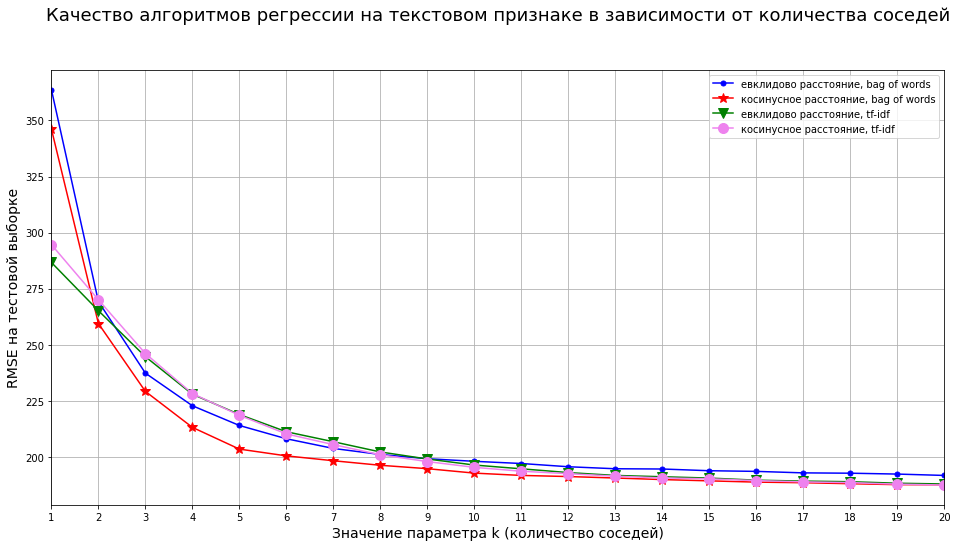

In [6]:
fig = plt.figure(figsize=(16, 8))
plt.plot(np.arange(1, 21), [363.7073148939345, 269.2571657610149, 237.34017340677138, 222.8111069336479, 214.01299781562557, 208.09336475709037, 203.7792350960008, 201.08719099447177, 199.1933003461142, 198.04064164216658, 197.06097962558172, 195.6188356651742, 194.72087389284067, 194.60695570612472, 193.84137921354034, 193.5495294662276, 192.88414359218217, 192.73706930555628, 192.35088836446172, 191.74277376338466], color='blue', marker='.', ms=10, label='евклидово расстояние, bag of words')
plt.plot(np.arange(1, 21), [346.1566146527965, 259.4608743662131, 229.20330074877225, 213.17244210404422, 203.48075067372838, 200.46363971508563, 198.29496189824644, 196.26772060797936, 194.7569224339046, 192.77686838515885, 191.7461681072099, 191.2469182486698, 190.5951763189845, 189.89789751591692, 189.32307475703934, 188.76389933373244, 188.4966417756949, 188.0524407076097, 187.63638306697348, 187.5794600806846], color='red', marker='*', ms=10, label='косинусное расстояние, bag of words')
plt.plot(np.arange(1, 21), [286.68310912623747, 265.19044654007394, 244.68694518921478, 227.94816685513337, 218.90641320165557, 211.222481744123, 206.7740508427289, 202.2070388500825, 199.06865980988158, 196.37568652030947, 194.69440168230184, 193.020517835002, 191.74334435076787, 191.15853386852925, 190.56886884048632, 189.6324113883297, 189.21908732023354, 188.95147697880523, 188.27228805488394, 187.93514501873486], color='green', marker='v', ms=10, label='евклидово расстояние, tf-idf')
plt.plot(np.arange(1, 21), [294.63147763723015, 270.0565489381399, 246.08837193443784, 228.23928142152965, 218.5642417868301, 210.24811958303067, 205.4855487443617, 200.95389341587347, 197.9199716904872, 195.34309412654628, 193.61848063917964, 192.51437554217398, 191.41659959619986, 190.6221074092689, 190.2295440540181, 189.43567297299205, 188.8752658544437, 188.5328226076564, 187.86018877623042, 187.4636296204296], color='violet', marker='o', ms=10, label='косинусное расстояние, tf-idf')
plt.title('Качество алгоритмов регрессии на текстовом признаке в зависимости от количества соседей', fontsize=18, y=1.1)
plt.xlabel('Значение параметра k (количество соседей)', fontsize=14)
plt.ylabel('RMSE на тестовой выборке', fontsize=14)
plt.xlim([1, 20])
plt.xticks(np.arange(1, 21))
plt.legend()
plt.grid()
plt.show()

Для преобразования bag of words лучше использовать косинусную меру, потому что она основана на угле между векторами. Если один текст в 2 раза длиннее другого, но они про одно и тоже, то первый вектор будет в 2 раза длиннее второго, но угол между ними будет очень маленький. На косинусной мере эти тексты будут близки, в то время как на евклидовой между ними будет большое расстояние.

Для tf-idf преобразования тоже лучше использовать косинусную меру, но разница с евклидовой уже не такая большая. Это объясняется тем, что компоненты вектора --- не количество слов в тексте, а важность конкретного слова для конкретного текста.

Лучшее качество было достигнуто с tf-idf, косинусной мерой при k = 20. RMSE была равна 187.46.

На графике видно, что при большом числе соседей все методы имеют примерно одинаковое качество, за исключением метода с евклидовым расстоянием и кодированием bag of words. RMSE этого метода ощутимо больше, чем у трех остальных.

## Задание 3.2

In [8]:
data = data.drop(columns=['id', 'host_id'])
data

,name,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,Clean & quiet apt home by the park,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,Skylit Midtown Castle,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,THE VILLAGE OF HARLEM....NEW YORK !,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,never,0.00,1,365
3,Cozy Entire Floor of Brownstone,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,Entire Apt: Spacious Studio/Loft by central park,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48890,Charming one bedroom - newly renovated rowhouse,Sabrina,Brooklyn,Bedford-Stuyvesant,40.67853,-73.94995,Private room,70,2,0,never,0.00,2,9
48891,Affordable room in Bushwick/East Williamsburg,Marisol,Brooklyn,Bushwick,40.70184,-73.93317,Private room,40,4,0,never,0.00,2,36
48892,Sunny Studio at Historical Neighborhood,Ilgar & Aysel,Manhattan,Harlem,40.81475,-73.94867,Entire home/apt,115,10,0,never,0.00,1,27
48893,43rd St. Time Square-cozy single bed,Taz,Manhattan,Hell's Kitchen,40.75751,-73.99112,Shared room,55,1,0,never,0.00,6,2


In [9]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(columns=['price']), data[['price']],
                                                    test_size=0.3, random_state=241)

In [10]:
cat_features = ['host_name', 'neighbourhood_group', 'neighbourhood', 'room_type',
                'last_review', 'calculated_host_listings_count', 'availability_365']

In [11]:
counters(X_train, y_train, X_test, cat_features, counter_type='std', num_folds=None)

In [12]:
X_test.host_name = (X_test.host_name.to_numpy() - X_train.host_name.mean()) / (X_train.host_name.std() * 2.5)
X_train.host_name = (X_train.host_name.to_numpy() - X_train.host_name.mean()) / (X_train.host_name.std() * 2.5)

In [13]:
X_test.neighbourhood_group = (X_test.neighbourhood_group.to_numpy() - X_train.neighbourhood_group.mean()) / (X_train.neighbourhood_group.std() * 2.5)
X_train.neighbourhood_group = (X_train.neighbourhood_group.to_numpy() - X_train.neighbourhood_group.mean()) / (X_train.neighbourhood_group.std() * 2.5)

In [14]:
X_test.neighbourhood = (X_test.neighbourhood.to_numpy() - X_train.neighbourhood.mean()) / (X_train.neighbourhood.std() * 2.5)
X_train.neighbourhood = (X_train.neighbourhood.to_numpy() - X_train.neighbourhood.mean()) / (X_train.neighbourhood.std() * 2.5)

In [15]:
X_test.latitude = (X_test.latitude.to_numpy() - X_train.latitude.mean()) / (X_train.latitude.std() * 2.5)
X_train.latitude = (X_train.latitude.to_numpy() - X_train.latitude.mean()) / (X_train.latitude.std() * 2.5)

In [16]:
X_test.longitude = (X_test.longitude.to_numpy() - X_train.longitude.mean()) / (X_train.longitude.std() * 2.5)
X_train.longitude = (X_train.longitude.to_numpy() - X_train.longitude.mean()) / (X_train.longitude.std() * 2.5)

In [17]:
X_test.room_type = (X_test.room_type.to_numpy() - X_train.room_type.mean()) / (X_train.room_type.std() * 2.5)
X_train.room_type = (X_train.room_type.to_numpy() - X_train.room_type.mean()) / (X_train.room_type.std() * 2.5)

In [18]:
X_test.minimum_nights = (X_test.minimum_nights.to_numpy() - X_train.minimum_nights.mean()) / (X_train.minimum_nights.std() * 2.5)
X_train.minimum_nights = (X_train.minimum_nights.to_numpy() - X_train.minimum_nights.mean()) / (X_train.minimum_nights.std() * 2.5)

In [19]:
X_test.number_of_reviews = (X_test.number_of_reviews.to_numpy() - X_train.number_of_reviews.mean()) / (X_train.number_of_reviews.std() * 2.5)
X_train.number_of_reviews = (X_train.number_of_reviews.to_numpy() - X_train.number_of_reviews.mean()) / (X_train.number_of_reviews.std() * 2.5)

In [20]:
X_test.last_review = (X_test.last_review.to_numpy() - X_train.last_review.mean()) / (X_train.last_review.std() * 2.5)
X_train.last_review = (X_train.last_review.to_numpy() - X_train.last_review.mean()) / (X_train.last_review.std() * 2.5)

In [21]:
X_test.reviews_per_month = (X_test.reviews_per_month.to_numpy() - X_train.reviews_per_month.mean()) / (X_train.reviews_per_month.std() * 2.5)
X_train.reviews_per_month = (X_train.reviews_per_month.to_numpy() - X_train.reviews_per_month.mean()) / (X_train.reviews_per_month.std() * 2.5)

In [22]:
X_test.calculated_host_listings_count = (X_test.calculated_host_listings_count.to_numpy() - X_train.calculated_host_listings_count.mean()) / (X_train.calculated_host_listings_count.std() * 2.5)
X_train.calculated_host_listings_count = (X_train.calculated_host_listings_count.to_numpy() - X_train.calculated_host_listings_count.mean()) / (X_train.calculated_host_listings_count.std() * 2.5)

In [23]:
X_test.availability_365 = (X_test.availability_365.to_numpy() - X_train.availability_365.mean()) / (X_train.availability_365.std() * 2.5)
X_train.availability_365 = (X_train.availability_365.to_numpy() - X_train.availability_365.mean()) / (X_train.availability_365.std() * 2.5)

In [24]:
X_train

,name,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
39319,Large bedroom,-0.079267,-0.271862,-0.400093,-0.679331,-0.151645,-0.387695,-0.100782,-0.101946,0.422582,0.632436,-0.384189,-0.141711
22796,Sun Drenched Gramercy/East Village!,0.021875,0.404497,0.232038,0.036604,-0.252676,0.377237,-0.100782,-0.075163,-0.139221,-0.128588,0.136847,0.098081
26190,Gorgeous single room in Sunnyside near Manhattan,-0.026669,-0.383239,-0.460385,0.133375,0.289608,-0.387695,-0.100782,-0.030524,-0.055835,-0.047314,-0.504801,1.118244
8161,Cozy UES Studio,0.085706,0.404497,-0.031505,0.326406,0.001800,0.377237,-0.121031,-0.209078,0.420842,-0.271434,0.136847,0.098081
32473,Modern & Cozy Studio In Best East Village Loca...,-0.258357,0.404497,-0.035696,-0.013723,-0.259152,0.377237,-0.100782,0.076608,-0.170884,0.403390,0.136847,-0.146396
...,...,...,...,...,...,...,...,...,...,...,...,...,...
41432,Sonder | Stock Exchange | Lovely 1BR + Lounge,0.034927,0.404497,-0.034338,-0.156573,-0.506288,0.377237,-0.100782,-0.075163,-0.172993,0.514218,-0.565397,0.136596
8690,"New Building, Best Location in NYC",0.062309,0.404497,0.419722,0.078213,-0.365536,-0.387695,-0.080534,-0.110873,-0.221577,-0.214789,0.136847,-0.255104
144,FLAT MACDONOUGH GARDEN,-0.246593,-0.271862,-0.118355,-0.338469,0.145920,0.377237,-0.080534,0.897955,-0.149860,0.152178,-0.161766,-0.290920
10987,Affordable Artistic Apartment,-0.234829,-0.271862,-0.174063,-0.601899,-0.508015,0.377237,-0.080534,0.094464,-0.154943,-0.086720,0.136847,0.098081


In [25]:
vectorizer = CountVectorizer(lowercase=True, stop_words=stopwords.words('english'), ngram_range=(1, 1), dtype=np.int8)
vec_train = vectorizer.fit_transform(X_train.name.to_numpy())
vec_test = vectorizer.transform(X_test.name.to_numpy())

In [26]:
tfidf = TfidfTransformer(smooth_idf=True)
vec_train_tfidf = tfidf.fit_transform(vec_train)
vec_test_tfidf = tfidf.transform(vec_test)

In [32]:
knn = KNNRegressor(19, strategy='brute', metric='euclidean', mode='distance')
knn.fit(np.hstack((vec_train_tfidf.toarray(), X_train.drop(columns=['name']).to_numpy())), y_train.to_numpy().flatten())
res = knn.predict(np.hstack((vec_test_tfidf.toarray(), X_test.drop(columns=['name']).to_numpy())))
print(math.sqrt(mean_squared_error(y_test.to_numpy().flatten(), res)))

194.43236664604876


In [ ]:
# rmse = 170.28 with random_state=1080 in train_test_split
# rmse = 194.43 with default random_state=241 in train_test_split
# I don't know how such a coincidence can be

Использование всех доступных признаков повлияло на качество регрессионной модели. В итоге удалось достичь самого высокого качества. RMSE равна 170.28 при разбиении на обучающую и тестовую выборки с random_state=1080 (на протяжении всего практического задания использовался именно такой random_state) и 194.43 при разбиении на обучающую и тестовую выборки с random_state=241 (такой random_state был в коде задания).

# Часть 4: Выводы

#### По итогу этого практического задания можно сделать следующие выводы:
* взвешанный метод kNN для регрессии лучше, чем не взвешанный
* если все признаки категориальные, то можно использовать функции расстояния на категориальных признаках, но если есть и числовые, то лучше заменять категориальные признаки на счетчики. Есть разные функции для счетчиков. Формировать счетчики можно как с фолдингом, чтобы не переобучаться, так и без него.
* текстовые признаки можно кодировать с помощью bag of words или tf-idf. Tf-idf учитывает важность слова для документа.
* используя все доступные признаки удалось достичь лучшего качества